# Evolution of the 1D model implementation : with Bednarsek acidity equation

This notebook demonstrates the use of the AcidityBedModel, which implements the Bednarsek et al. (2022) linear mortality equation for ocean acidification effects on pteropods.


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from seapopym.configuration.acidity import (
    ForcingParameter,
)
from seapopym.configuration.acidity_bed import (
    AcidityBedConfiguration,
    FunctionalGroupParameter,
    FunctionalGroupUnit,
    FunctionalTypeParameter,
)
from seapopym.configuration.no_transport import (
    ForcingUnit,
    MigratoryTypeParameter,
)
from seapopym.model import AcidityBedModel
from seapopym.standard.coordinate_authority import (
    create_latitude_coordinate,
    create_layer_coordinate,
    create_longitude_coordinate,
    create_time_coordinate,
)
from seapopym.standard.units import StandardUnitsLabels


## Generating data for the 1D simulation

Let's generate some data for the 1D simulation. The AcidityBedModel requires temperature, primary production, and acidity data. The Bednarsek model uses a linear mortality equation based on these environmental variables.


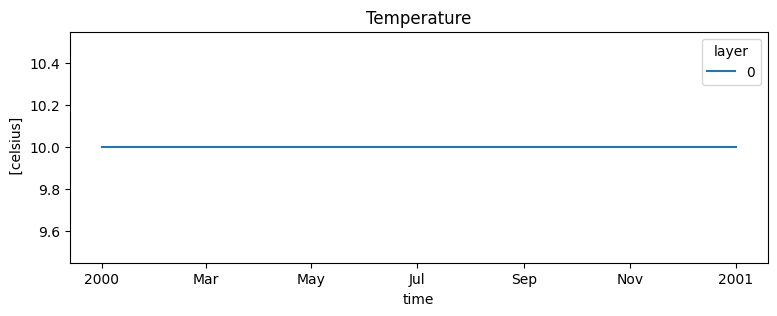

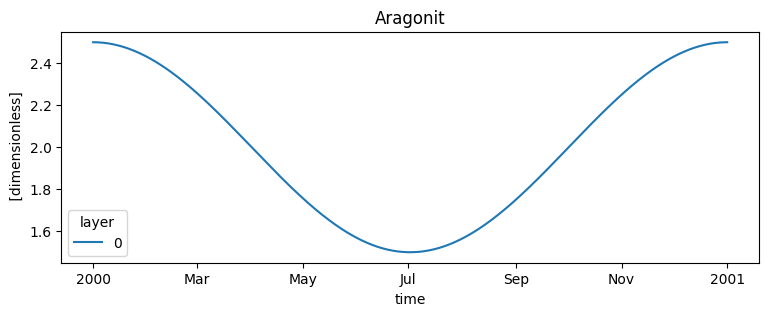

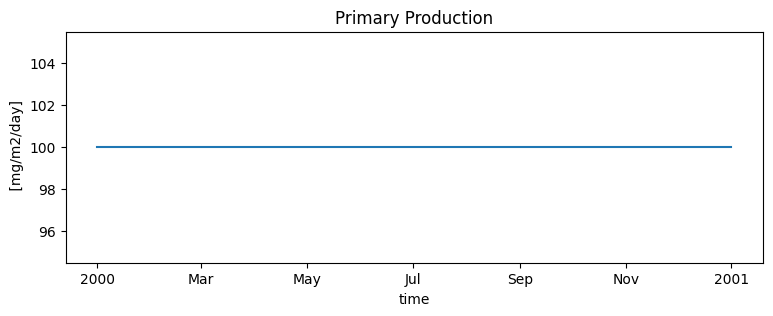

In [14]:
time_axis = create_time_coordinate(pd.date_range("2000-01-01", "2001-01-01", freq="D"))
n = int(time_axis.size)
t = np.linspace(0, 1, n)
temperature = np.ones_like(t) * 10
acidity = 2 + 0.5 * np.cos(2 * np.pi * t)

temperature = xr.DataArray(
    dims=["T", "Y", "X", "Z"],
    coords={
        "T": create_time_coordinate(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
        "Z": create_layer_coordinate([0]),
    },
    attrs={"units": StandardUnitsLabels.temperature},
    data=temperature[:, np.newaxis, np.newaxis, np.newaxis],
)

plt.figure(figsize=(9, 3))
temperature[:, 0, 0].cf.plot.line(x="T")
plt.title("Temperature")
plt.show()

acidity = xr.DataArray(
    dims=["T", "Y", "X", "Z"],
    coords={
        "T": create_time_coordinate(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
        "Z": create_layer_coordinate([0]),
    },
    attrs={"units": StandardUnitsLabels.acidity},
    data=acidity[:, np.newaxis, np.newaxis, np.newaxis],
)

plt.figure(figsize=(9, 3))
acidity[:, 0, 0].cf.plot.line(x="T")
plt.title("Aragonit")
plt.show()

primary_production = xr.DataArray(
    dims=["T", "Y", "X"],
    coords={
        "T": create_time_coordinate(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
    },
    attrs={"units": "mg/m2/day"},
    data=np.full((n, 1, 1), 100.0),
)

plt.figure(figsize=(9, 3))
primary_production.plot()
plt.title("Primary Production")
plt.show()

dataset = xr.Dataset({"temperature": temperature, "primary_production": primary_production, "acidity": acidity})

## Initialize the Bednarsek model


In [15]:
f_groups = FunctionalGroupParameter(
    functional_group=[
        FunctionalGroupUnit(
            name="Pteropod",
            energy_transfert=0.1668,
            migratory_type=MigratoryTypeParameter(day_layer=0, night_layer=0),
            functional_type=FunctionalTypeParameter(
                lambda_0=-19.4,
                gamma_lambda_temperature=11.5,
                gamma_lambda_acidity=-32.7,
                survival_rate_0=13.49,
                gamma_survival_rate_temperature=-2.475,
                gamma_survival_rate_acidity=10.10,
                tr_0=10.38,
                gamma_tr=-0.11,
            ),
        )
    ]
)

p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=dataset["temperature"]),
    primary_production=ForcingUnit(forcing=dataset["primary_production"]),
    acidity=ForcingUnit(forcing=dataset["acidity"]),
)

parameters = AcidityBedConfiguration(forcing=p_param, functional_group=f_groups)

primary_production unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.
primary_production unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.


## Run the Bednarsek model

The AcidityBedModel uses the linear Bednarsek mortality equation instead of the exponential equation used in the standard AcidityModel.


In [16]:
with AcidityBedModel.from_configuration(configuration=parameters) as bednarsek_model:
    bednarsek_model.state
    bednarsek_model.run()
    display(bednarsek_model.state)
    biomass = bednarsek_model.state["biomass"]
    state = bednarsek_model.state.copy()

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:350: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  fill_value = asarray(fill_value)
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:258: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  return xr.concat(all_dataset, dim=coordinates, combine_attrs="no_conflicts")


<xarray.Dataset> Size: 40kB
Dimensions:                          (functional_group: 1, T: 367, Y: 1, X: 1,
                                      cohort: 11, Z: 1)
Coordinates:
  * functional_group                 (functional_group) int64 8B 0
  * T                                (T) datetime64[ns] 3kB 2000-01-01 ... 20...
  * Y                                (Y) int64 8B 0
  * X                                (X) int64 8B 0
  * cohort                           (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * Z                                (Z) int64 8B 0
Data variables: (12/35)
    biomass                          (functional_group, T, Y, X) float64 3kB ...
    recruited                        (functional_group, T, Y, X) float64 3kB ...
    mortality_field                  (functional_group, T, Y, X) float64 3kB ...
    survival_rate                    (functional_group, T, Y, X) float64 3kB ...
    mask_temperature                 (functional_group, T, Y, X, cohort) bool 4kB ...
    min_temperature                  (functional_group, cohort) float64 88B 2...
    ...                               ...
    max_timestep                     (functional_group, cohort) float64 88B 1...
    mean_timestep                    (functional_group, cohort) float64 88B 1...
    timestep                         float64 8B 1.0
    angle_horizon_sun                float64 8B 0.0
    compute_initial_conditions       bool 1B False
    compute_preproduction            bool 1B False

## Plotting the results

### The biomass evolution over time using Bednarsek mortality equation

The linear Bednarsek equation provides a different mortality response to temperature and acidity compared to the exponential equation.


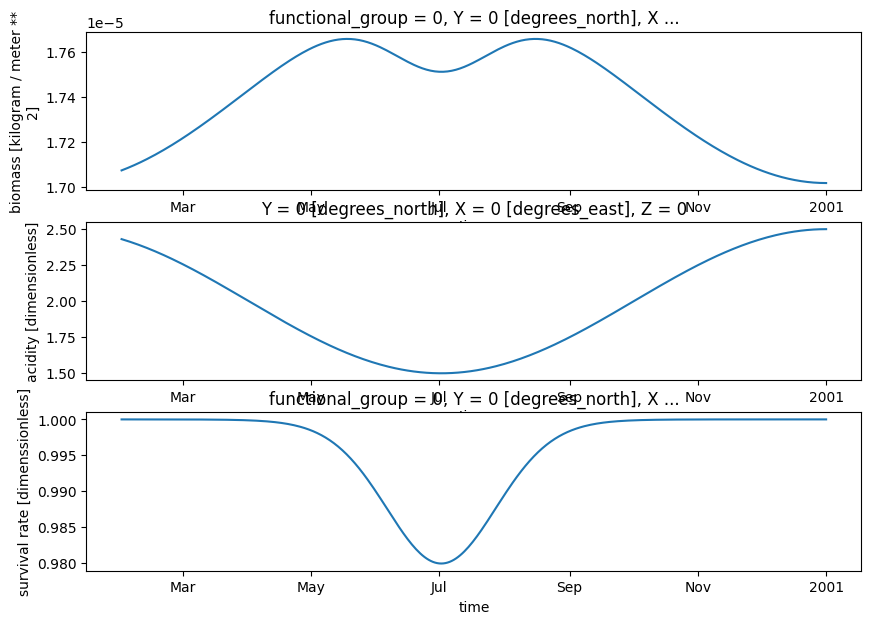

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(10, 7))
biomass.sel(T=slice("2000-02-01", None)).squeeze().plot.line(x="T", hue="functional_group", ax=axes[0])
state.sel(T=slice("2000-02-01", None)).acidity.plot(ax=axes[1])
state.sel(T=slice("2000-02-01", None)).survival_rate.plot(ax=axes[2])